### Importing the packages required

In [1]:
import os
import warnings
import math
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split 
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score,roc_curve,auc, f1_score, roc_auc_score,confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, normalize
from scipy import ndimage
import seaborn as sns

### Load train and test data

In [2]:
test_data = pd.read_csv("exoTest.csv").fillna(0)
train_data = pd.read_csv("exoTrain.csv").fillna(0)

In [3]:
train_data.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


### convert label value 1 and 2 into binary value

In [4]:
categ = {2: 1,1: 0}
train_data.LABEL = [categ[item] for item in train_data.LABEL]
test_data.LABEL = [categ[item] for item in test_data.LABEL]

### visualize data for understanding

Text(0.5, 1.0, 'Class Distributions \n (0: Not Exoplanet || 1: Exoplanet)')

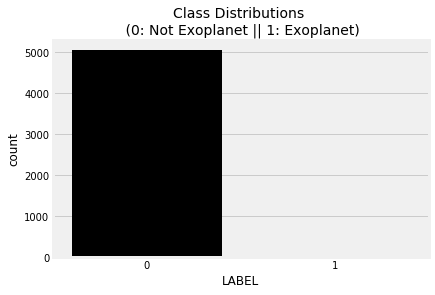

In [5]:
plt.figure(figsize=(6,4))
colors = ["0", "1"]
sns.countplot('LABEL', data=train_data, palette=colors)
plt.title('Class Distributions \n (0: Not Exoplanet || 1: Exoplanet)', fontsize=14)

### split train data set into train and test 

In [6]:
#splitting the data
x_train = train_data.drop(["LABEL"],axis=1)
y_train = train_data["LABEL"]   
x_test = test_data.drop(["LABEL"],axis=1)
y_test = test_data["LABEL"]

### Normalize the data

In [7]:
x_train = normalized = normalize(x_train)
x_test = normalize(x_test)

### Applying of gaussian filter

In [8]:
x_train = filtered = ndimage.filters.gaussian_filter(x_train, sigma=10)
x_test = ndimage.filters.gaussian_filter(x_test, sigma=10)

### Feature scaling

In [9]:
std_scaler = StandardScaler()
x_train = scaled = std_scaler.fit_transform(x_train)
x_test = std_scaler.fit_transform(x_test)

### Perform Dimentioanlity reduction

In [21]:
from sklearn.decomposition import PCA
pca = PCA() 
X_train = pca.fit_transform(x_train)
X_test = pca.transform(x_test)
total=sum(pca.explained_variance_)
k=0
current_variance=0
while current_variance/total < 0.90:
    current_variance += pca.explained_variance_[k]
    k=k+1
print(k)

24


### Apply PCA with 24 components

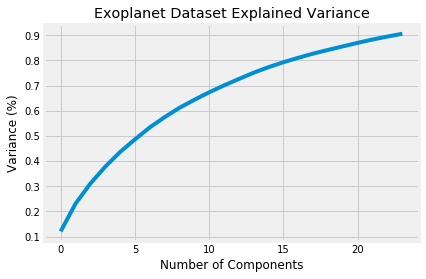

In [22]:
pca = PCA(n_components=24)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Exoplanet Dataset Explained Variance')
plt.show()

### convert numpy to dataframe

In [23]:
df = pd.DataFrame.from_records(x_train)     
corr = df.corr(method='kendall')

### Resampling as the data is highly unbalanced.

In [25]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=27)
x_train_res, y_train_res = sm.fit_sample(x_train, y_train.ravel()) 

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Before OverSampling, counts of label '1': 37
Before OverSampling, counts of label '0': 5050 

After OverSampling, counts of label '1': 5050
After OverSampling, counts of label '0': 5050


### Defining model function to be used by different algorithms 

In [26]:
#model building
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score,roc_curve,auc, f1_score, roc_auc_score,confusion_matrix, accuracy_score, classification_report
def model(classifier,dtrain_x,dtrain_y,dtest_x,dtest_y):
    #fit the model
    classifier.fit(dtrain_x,dtrain_y)
    predictions = classifier.predict(dtest_x)
    
    #Cross validation
    accuracies = cross_val_score(estimator = classifier, X = x_train_res, y = y_train_res, cv = 5, n_jobs = -1)
    mean = accuracies.mean()
    variance = accuracies.std()
    print("Accuracy mean: "+ str(mean))
    print("Accuracy variance: "+ str(variance))
    
    #Accuracy
    print ("\naccuracy_score :",accuracy_score(dtest_y,predictions))
    #Classification report
    print ("\nclassification report :\n",(classification_report(dtest_y,predictions)))
    
    #Confusion matrix
    plt.figure(figsize=(10,7))
    plt.subplot(221)
    sns.heatmap(confusion_matrix(dtest_y,predictions),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
    plt.title("CONFUSION MATRIX",fontsize=15)
    """
    #ROC curve and Area under the curve plotting
    predicting_probabilites = classifier.predict_proba(dtest_x)[:,1]
    fpr,tpr,thresholds = roc_curve(dtest_y,predicting_probabilites)
    plt.subplot(222)
    plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")
    plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
    plt.legend(loc = "best")
    plt.title("ROC - CURVE & AREA UNDER CURVE",fontsize=20)
    """

### K-NN classifier

Accuracy mean: 0.9982178217821783
Accuracy variance: 0.00251648812418591

accuracy_score : 0.9912280701754386

classification report :
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       565
           1       0.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       0.50      0.50      0.50       570
weighted avg       0.98      0.99      0.99       570



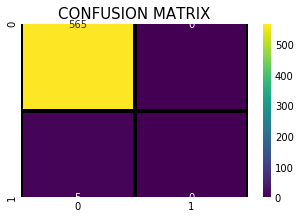

In [27]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
model(knn,x_train_res,y_train_res,x_test,y_test)

### Random Forest

Accuracy mean: 0.9997029702970297
Accuracy variance: 0.0005940594059405946

accuracy_score : 0.9912280701754386

classification report :
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       565
           1       0.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       0.50      0.50      0.50       570
weighted avg       0.98      0.99      0.99       570



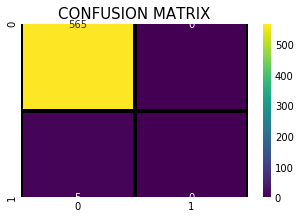

In [28]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier()
model(rf_classifier,x_train_res,y_train_res,x_test,y_test) 

### SVM

Accuracy mean: 0.9992079207920792
Accuracy variance: 0.0015841584158415856

accuracy_score : 0.9912280701754386

classification report :
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       565
           1       0.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       0.50      0.50      0.50       570
weighted avg       0.98      0.99      0.99       570



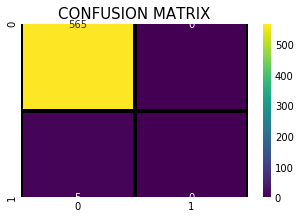

In [29]:
from sklearn.svm import SVC
SVM_model=SVC()
model(SVM_model,x_train_res,y_train_res,x_test,y_test) 